In [1]:
import numpy as np
from point_history import getmes
import pickle
import datetime
from get_point_map import get
from get_point_history import pget
from netCDF4 import Dataset
import pandas as pd
from ipywidgets import interact

In [2]:
import folium

In [3]:
from pandas.compat import u

In [4]:
%matplotlib notebook

In [5]:
path='../../../tide_test/'

In [6]:
path='/mnt/rmdisk/2016N/'

In [7]:
path0='/mnt/rmdisk/2016N/1/1/00/'

In [8]:
basename='med'

In [9]:
with open(path0+'med.pkl', 'r') as f:
    ptr=pickle.load(f)

In [10]:
t1='20160101.00'

In [11]:
t2='20160111.00'

In [12]:
sdate=datetime.datetime.strptime(t1,'%Y%m%d.%H')

In [13]:
edate=datetime.datetime.strptime(t2,'%Y%m%d.%H')

In [14]:
hdata=Dataset(path0+'trih-med.nc')

In [15]:
hdata.variables.keys()

[u'NAMST',
 u'ALFAS',
 u'SIG_LYR',
 u'SIG_INTF',
 u'KMAXOUT',
 u'KMAXOUT_RESTR',
 u'time',
 u'ZKFS',
 u'ZWL',
 u'ZCURU',
 u'ZCURV',
 u'ZQXK',
 u'ZQYK',
 u'ZTAUKS',
 u'ZTAUET',
 u'ZWNDSPD',
 u'ZWNDDIR',
 u'PATM',
 u'XSTAT',
 u'YSTAT',
 u'MNSTAT',
 u'DPS']

In [16]:
%%skip
hdata.variables['XSTAT']

In [17]:
%%skip
hdata.variables['DPS'][:][0,:]


In [16]:
rt=[]
hs=[]
mt=[]
mh=[]
ht=[]
hh=[]
tota=[]
blons=[]
blats=[]
gnames=[]
gid=[]
for n in ptr.keys():
#  print n
    t,s,plat,plon,bname,bid = getmes(sdate,edate,n)
    rt.append(t)
    hs.append(s)
    blons.append(plon)
    blats.append(plat)
    gnames.append(bname)
    gid.append(bid)
    dic0={'t_gauge':t, 'sh':[a for [a,b,c] in s], 'tide':[b for [a,b,c] in s], 'ss':[c for [a,b,c] in s]}
    data0=pd.DataFrame(dic0)
    data0=data0.set_index('t_gauge')
    tcw,cw=get(t1,t2,path,basename,plat,plon)
    mt.append(tcw)
    mh.append(cw)
    dic1={'t_map':tcw, 's_map':cw}
    data1=pd.DataFrame.from_dict(dic1)
    data1=data1.set_index('t_map')
    data=data0.join(data1, how='outer')
    hcw,hw=pget(t1,t2,path,basename,ptr[n])
    ht.append(hcw)
    hh.append(hw)
    dic2={'t_his':hcw, 's_his':hw}
    data2=pd.DataFrame.from_dict(dic2)
    data2=data2.set_index('t_his')
    data=data.join(data2, how='outer')
    tota.append(data)

Create a dataframe with location info

In [17]:
dic3={'ID':gid,'Location':gnames,'lon':blons,'lat':blats}

In [49]:
infor=pd.DataFrame.from_dict(dic3)

In [50]:
infor=infor.set_index(['ID'])

In [51]:
infor.head()

,Location,lat,lon
ID,,,
2560,Ierapetra,35.004,25.739
2561,Itea,38.431,22.423
2562,Hrakleio,35.349,25.153
2563,Kasos,35.419,26.922
2564,Kasteli,35.514,23.637


In [21]:
#check that the 'returned' iDs are the same as the read ones
np.array_equal(infor.index.values.astype(int), np.array(ptr.keys()))

True

concatenate all data with respect to the location id

In [22]:
tota=pd.concat(tota, keys=ptr.keys()[:])

In [23]:
tota.head()

sh   ss tide  s_map     s_his
2560 2016-01-01 00:00:00  NaN  NaN  NaN    0.0  0.000000
     2016-01-01 00:01:00  NaN  NaN  NaN    NaN  0.000036
     2016-01-01 00:02:00  NaN  NaN  NaN    NaN  0.000170
     2016-01-01 00:03:00  NaN  NaN  NaN    NaN  0.000450
     2016-01-01 00:04:00  NaN  NaN  NaN    NaN  0.000806

In [25]:
#save it
tota.to_pickle('tmp/tota.pkl')

In [18]:
#read it
tota=pd.read_pickle('tmp/tota.pkl')

Convert to float numbers

In [19]:
tota=tota.apply(pd.to_numeric)

In [ ]:
#for i in ptr.keys():
#      tota.loc[i][['sh','ss','s_map','s_his']] = tota.loc[i][['sh','ss','s_map','s_his']].apply(pd.to_numeric)

In [ ]:
#tota['s_his'].unstack(level=0)

In [ ]:
# test that all observation points are good
for i in ptr.keys():
    cl=tota.xs(i)[['s_his']].dropna()
    print cl.max()

Checking whether the get from map function gives the same data as get_point

In [31]:
for i in ptr.keys():
    cl=tota.xs(i)[['s_map','s_his']].dropna().resample('H').mean()
    cc=cl['s_map'] != cl['s_his']
    bol=cc.sum()
    if bol != 0 : print i

1606
1609
1852


plot for visual confirmation 

<IPython.core.display.Javascript object>


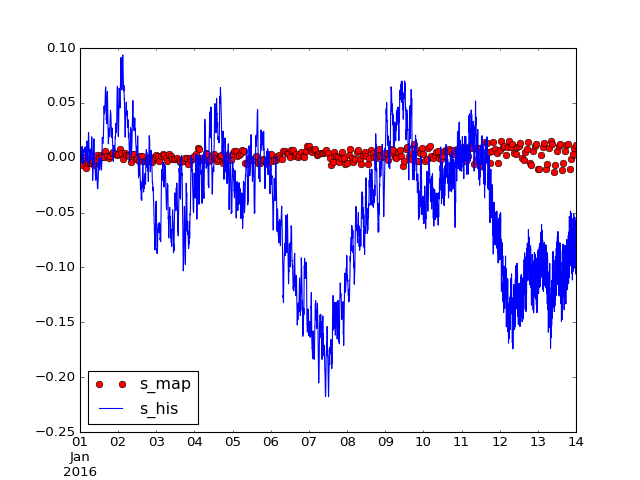

In [34]:
tota.xs(1606)[['s_map','s_his']].plot(style=['ro','b-'])

interpolate on measurements with window applied to both directions

<IPython.core.display.Javascript object>


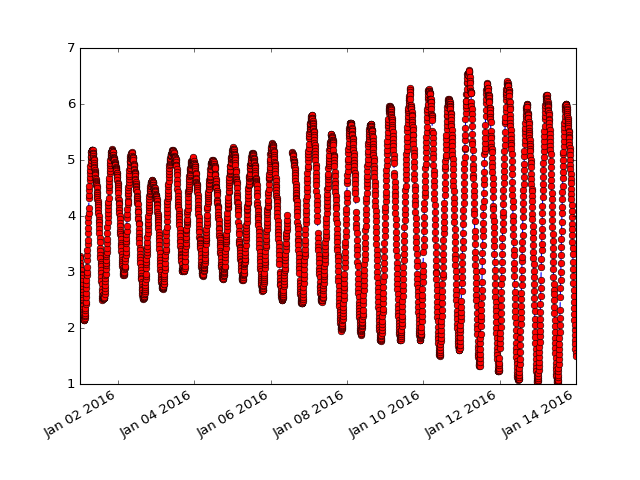

In [152]:
ax=tota.xs(1580)['sh'].apply(pd.to_numeric).interpolate(limit=6,limit_direaction='both').plot()
tota.xs(1580)['sh'].apply(pd.to_numeric).plot(ax=ax, style=['ro'])

In [119]:
#tota.xs(1580).apply(pd.to_numeric).dropna(thresh=3).plot()

Plot interactively any location

In [20]:
def plotf(i):
    try:
        ax=tota.xs(np.int(i))[['sh','ss','tide']].dropna().apply(pd.to_numeric).plot(style=['r-','g-','b-'])
        tota.xs(np.int(i))[['s_map','s_his']].dropna().apply(pd.to_numeric).plot(ax=ax, style=['co','k-'])
    except:
        tota.xs(np.int(i))[['s_map','s_his']].dropna().apply(pd.to_numeric).plot(style=['co','k-'])

In [27]:
ii=list(np.sort(ptr.keys()))

<IPython.core.display.Javascript object>


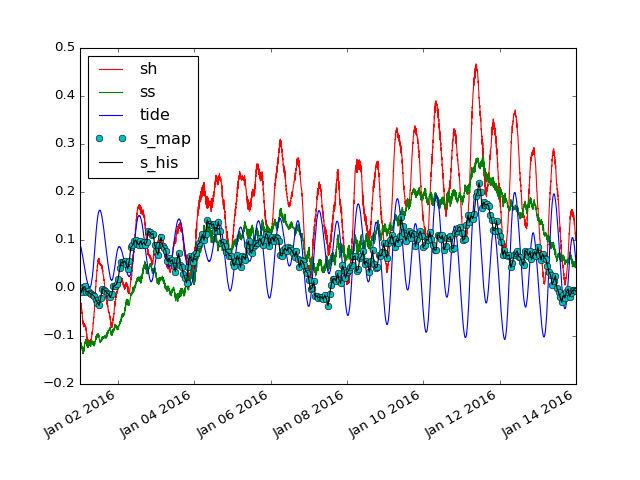

In [28]:
interact(plotf,i=ii)

show locations on map

In [35]:
mlon=infor['lon'].apply(pd.to_numeric).mean()
mlat=infor['lat'].apply(pd.to_numeric).mean()

In [36]:
m = folium.Map(location=[mlat, mlon], zoom_start=4)

set the names to unicode

In [60]:
infor['Location']=pd.Series(map(u,infor['Location']),index=infor.index)

In [62]:
for i in range(infor.shape[0]):
        folium.Marker(infor[['lat','lon']].values[i].astype(float), popup=infor['Location'].values[i]).add_to(m)

In [108]:
#m

### superimpose the numerical location nodes.

In [89]:
dm = Dataset(path0+'trim-'+basename+'.nc')
dh = Dataset(path0+'trih-'+basename+'.nc')

In [91]:
xz=dm.variables['XZ'][:] 
yz=dm.variables['YZ'][:]

In [92]:
h=dh.variables['ZWL'][:]
time=dh.variables['time'][:]

In [93]:
ij=dh.variables['MNSTAT'][0,:,:] #ij of obs points

In [94]:
depth=dh.variables['DPS'][:] # depth at obs locations

In [102]:
mlons=[]
mlats=[]
for klon,klat in ij:
    mlons.append(xz[klon,klat])
    mlats.append(yz[klon,klat])

In [103]:
mdic={'mlons':mlons, 'mlats':mlats}

In [104]:
mpoints=pd.DataFrame.from_dict(mdic)

In [105]:
mpoints=mpoints.apply(pd.to_numeric)

In [106]:
mpoints.head()

,mlats,mlons
0,41.311619,2.282713
1,35.625000,-5.065772
2,39.036972,8.161501
3,36.093311,-5.266185
4,43.519367,8.027892


In [110]:
for i in range(mpoints.shape[0]):
        folium.CircleMarker(mpoints[['mlats','mlons']].values[i].astype(float)).add_to(m)

In [111]:
m

## check variance

In [44]:
obs = tota.xs(899)[['ss']].dropna().apply(pd.to_numeric)

In [49]:
ma = obs.rolling(10).mean()

In [50]:
mstd = obs.rolling(10).std()

In [47]:
import matplotlib.pyplot as plt

In [66]:
mstd.index.values

array(['2016-01-01T00:01:00.000000000', '2016-01-01T00:07:00.000000000',
       '2016-01-01T00:14:00.000000000', ...,
       '2016-01-13T23:52:00.000000000', '2016-01-13T23:58:00.000000000',
       '2016-01-14T00:00:00.000000000'], dtype='datetime64[ns]')

In [60]:
ma.shape

(3117, 1)

<IPython.core.display.Javascript object>


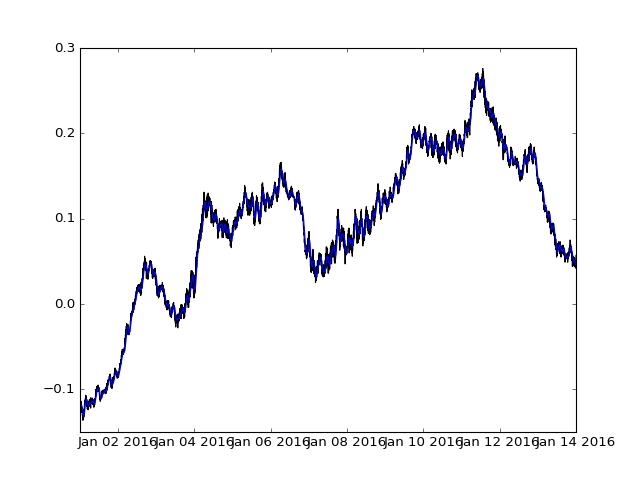

ValueError: Argument dimensions are incompatible

In [65]:
plt.figure()
plt.plot(obs.index, obs, 'k')
plt.plot(ma.index, ma, 'b')
plt.fill_between(mstd.index.values, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)

In [ ]:
# tota['s_his'].isnull().any()

In [47]:
#tota['s_his'][tota['s_his'].isnull()]